#### Importando dependências e definindo funções úteis

In [1]:
# TODO plotar matriz de confusão considerando diferentes quantidades de neuronios e diferentes quantidades de camadas
# testar mudando funções de ativação

In [2]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.neural_network import MLPClassifier
import numpy as np

In [3]:


def plot_confusion_matrix(model, X, y, ax):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot(ax=ax)
    #plt.title(type(model).__name__)
    #plt.show()
    
    data = {
        'model_shape': model.hidden_layer_sizes,
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'accuracy': accuracy_score(y, y_pred),
        'roc': roc_auc_score(y, y_pred_prob)
    }
    
    return data

#### Lendo a base de dados e fazendo pré-processamento inicial

In [4]:
base = pd.read_csv("../dataset/observations.csv")

In [5]:
base.shape

(310, 14)

In [6]:
base.head()

Col1       Col2       Col3       Col4        Col5       Col6  \
0  63.027817  22.552586  39.609117  40.475232   98.672917  -0.254400   
1  39.056951  10.060991  25.015378  28.995960  114.405425   4.564259   
2  68.832021  22.218482  50.092194  46.613539  105.985135  -3.530317   
3  69.297008  24.652878  44.311238  44.644130  101.868495  11.211523   
4  49.712859   9.652075  28.317406  40.060784  108.168725   7.918501   

       Col7     Col8     Col9     Col10      Col11    Col12 Class_att  \
0  0.744503  12.5661  14.5386  15.30468 -28.658501  43.5123  Abnormal   
1  0.415186  12.8874  17.5323  16.78486 -25.530607  16.1102  Abnormal   
2  0.474889  26.8343  17.4861  16.65897 -29.031888  19.2221  Abnormal   
3  0.369345  23.5603  12.7074  11.42447 -30.470246  18.8329  Abnormal   
4  0.543360  35.4940  15.9546   8.87237 -16.378376  24.9171  Abnormal   

                                         Unnamed: 13  
0                                                NaN  
1                                                NaN  
2  Prediction is done by using binary classificat...  
3                                                NaN  
4                                                NaN

In [7]:
# dropping useless column 'Unnamed: 13'
base = base.drop(columns=['Unnamed: 13'])

In [8]:
# renaming columns
base.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope', 'class']

In [9]:
# Ordinal encoding for target feature
# 1 --> Abnormal
# 0 --> Normal
oe = OrdinalEncoder(dtype=np.intc, categories=[['Normal', 'Abnormal']])

# transform data and add new integer target column to base
base['TARGET'] = oe.fit_transform(base['class'].to_numpy().reshape(-1,1))

In [10]:
base.head()

pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0         63.027817    22.552586              39.609117     40.475232   
1         39.056951    10.060991              25.015378     28.995960   
2         68.832021    22.218482              50.092194     46.613539   
3         69.297008    24.652878              44.311238     44.644130   
4         49.712859     9.652075              28.317406     40.060784   

   pelvic_radius  degree_spondylolisthesis  pelvic_slope  direct_tilt  \
0      98.672917                 -0.254400      0.744503      12.5661   
1     114.405425                  4.564259      0.415186      12.8874   
2     105.985135                 -3.530317      0.474889      26.8343   
3     101.868495                 11.211523      0.369345      23.5603   
4     108.168725                  7.918501      0.543360      35.4940   

   thoracic_slope  cervical_tilt  sacrum_angle  scoliosis_slope     class  \
0         14.5386       15.30468    -28.658501          43.5123  Abnormal   
1         17.5323       16.78486    -25.530607          16.1102  Abnormal   
2         17.4861       16.65897    -29.031888          19.2221  Abnormal   
3         12.7074       11.42447    -30.470246          18.8329  Abnormal   
4         15.9546        8.87237    -16.378376          24.9171  Abnormal   

   TARGET  
0       1  
1       1  
2       1  
3       1  
4       1

#### Entendendo a relação dois a dois entre as features da base na determinância da classe alvo

In [11]:
pairs = []

for i in range(12):
    for j in range(12):
        if i != j:
            coli = base.columns[i]
            colj = base.columns[j]
            if ([coli, colj] not in pairs) and ([colj, coli] not in pairs):
                pairs.append([coli, colj])

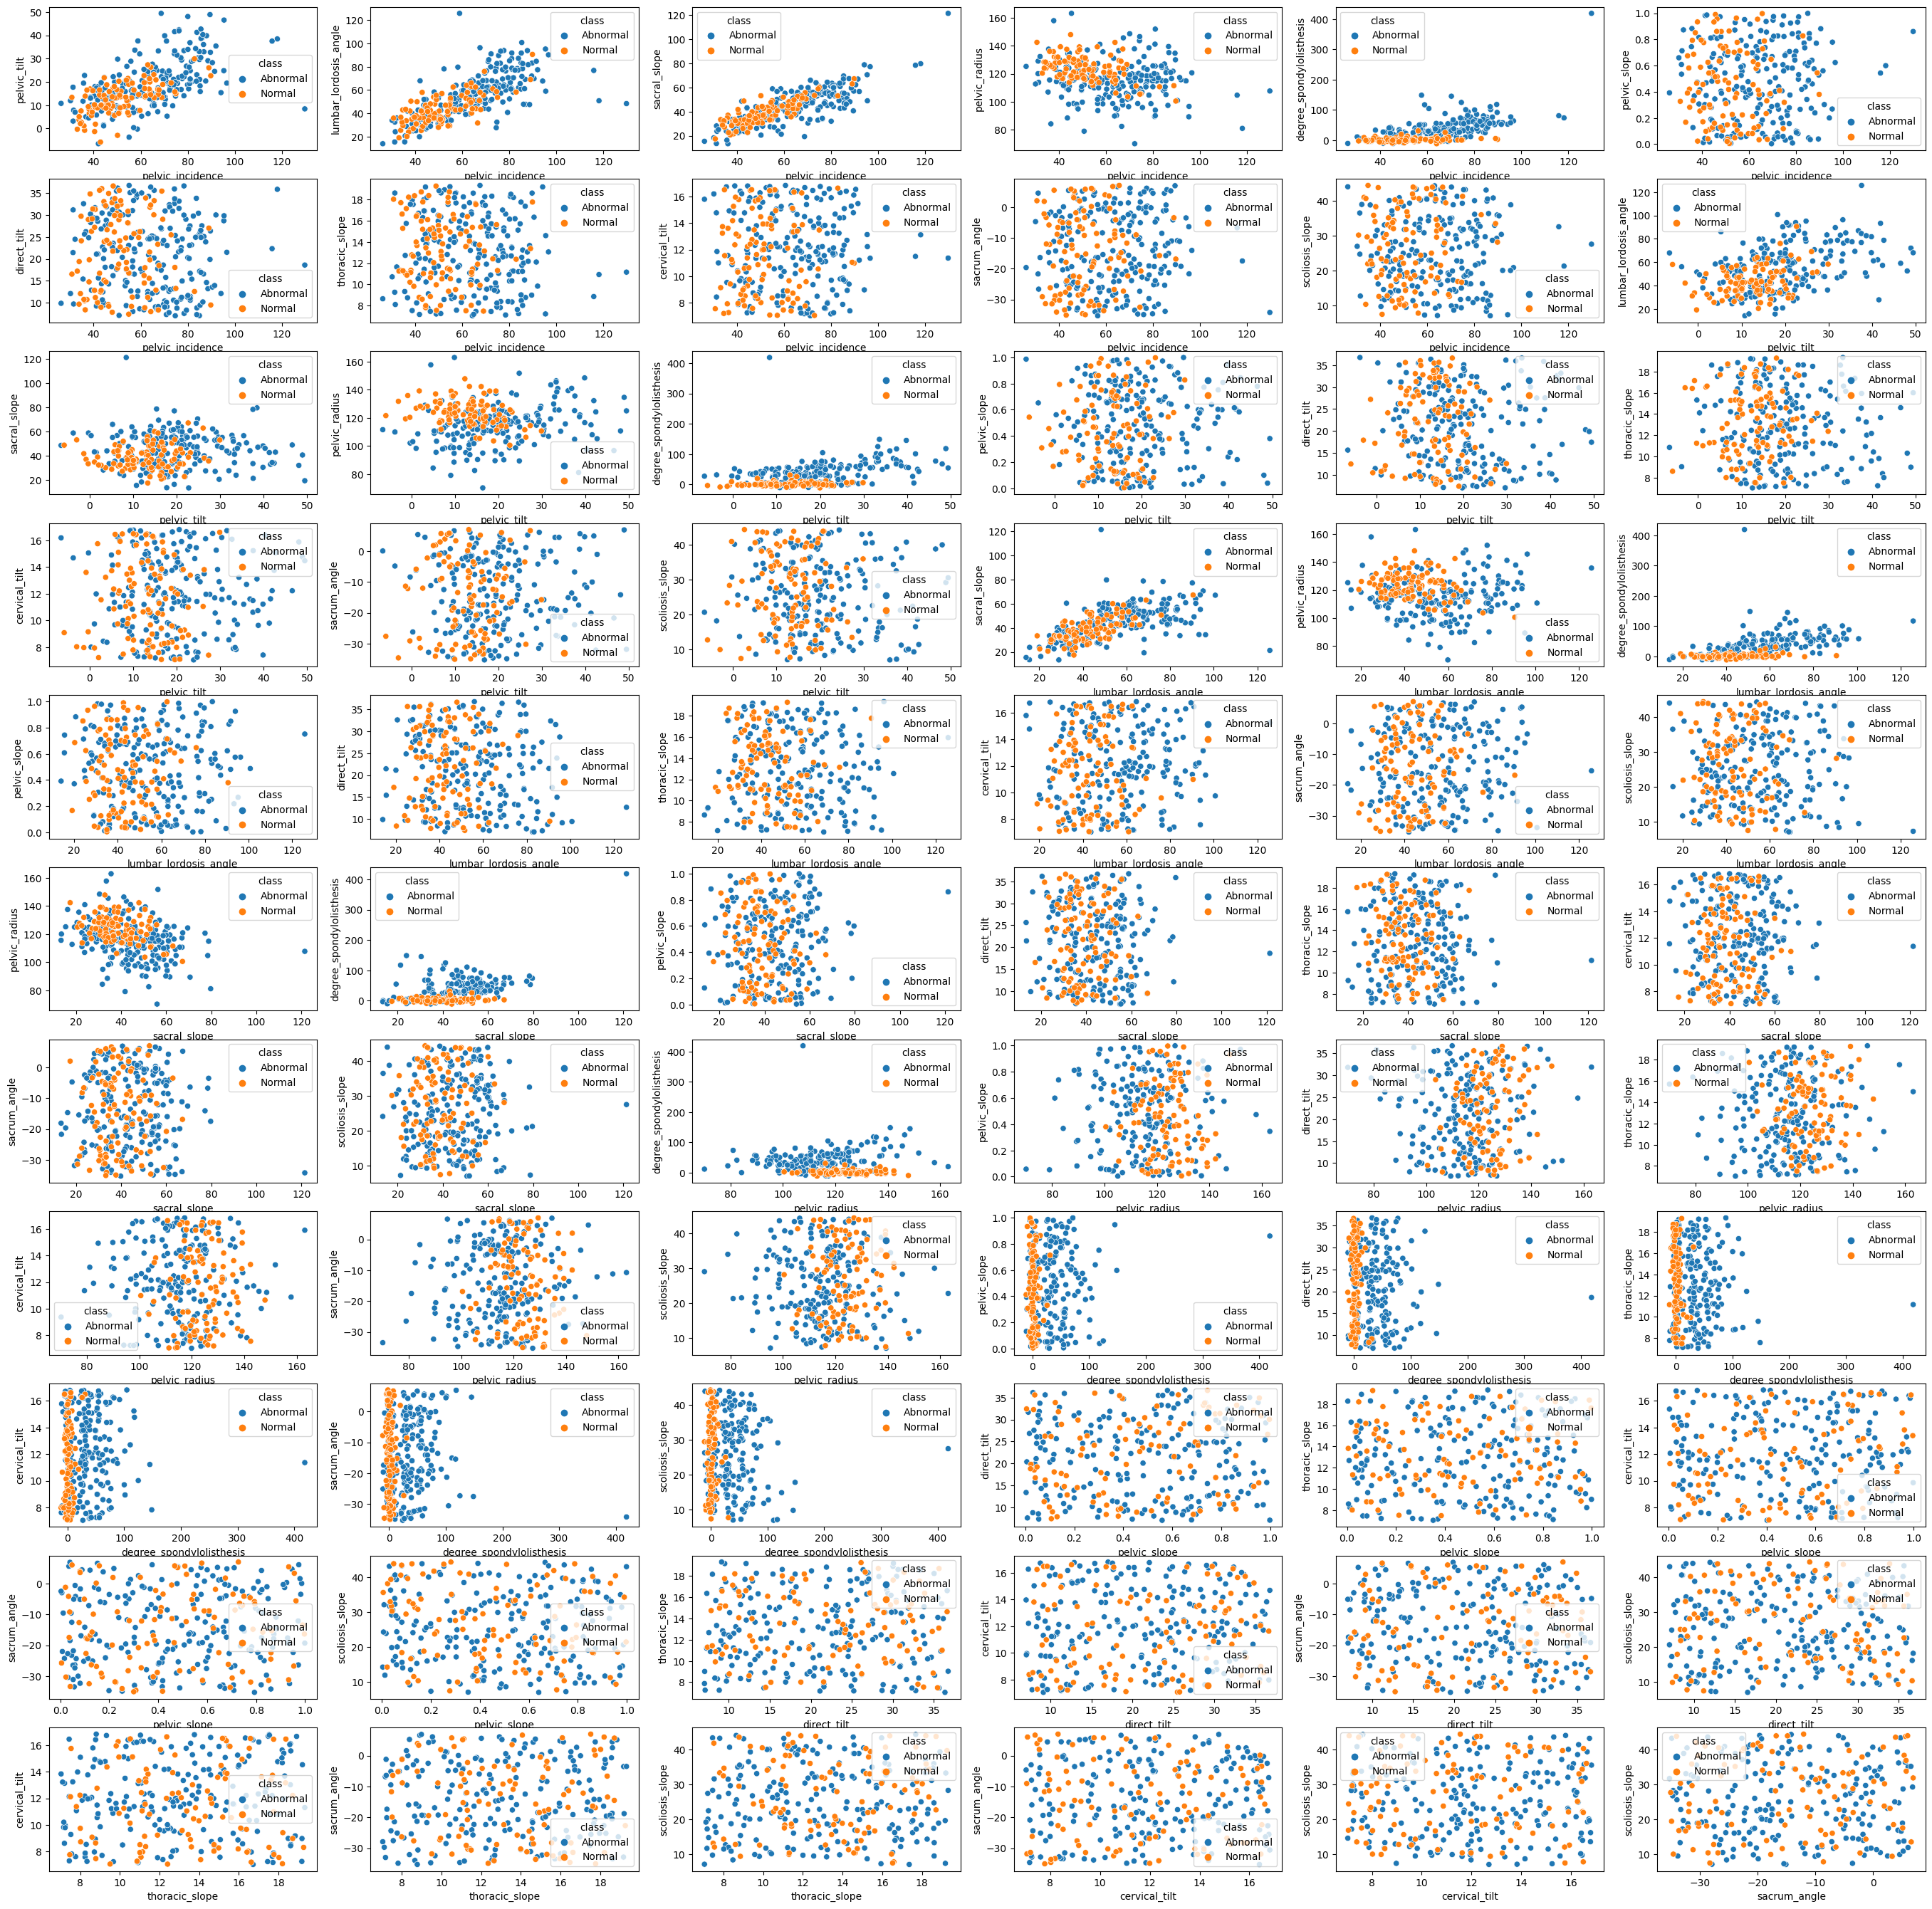

In [12]:
fig, ax = plt.subplots(nrows=11, ncols=6, figsize=(34,34))

i=0
j=0
for pair in pairs:
    if j == 6:
        j=0
        i += 1
    data = base[[pair[0], pair[1], 'class']]
    sns.scatterplot(data=data, x=pair[0], y=pair[1], hue="class", ax=ax[i][j])
    j += 1

plt.show()

#### Using pearson correlation to select features

In [13]:
base = base.drop(columns=['class'])

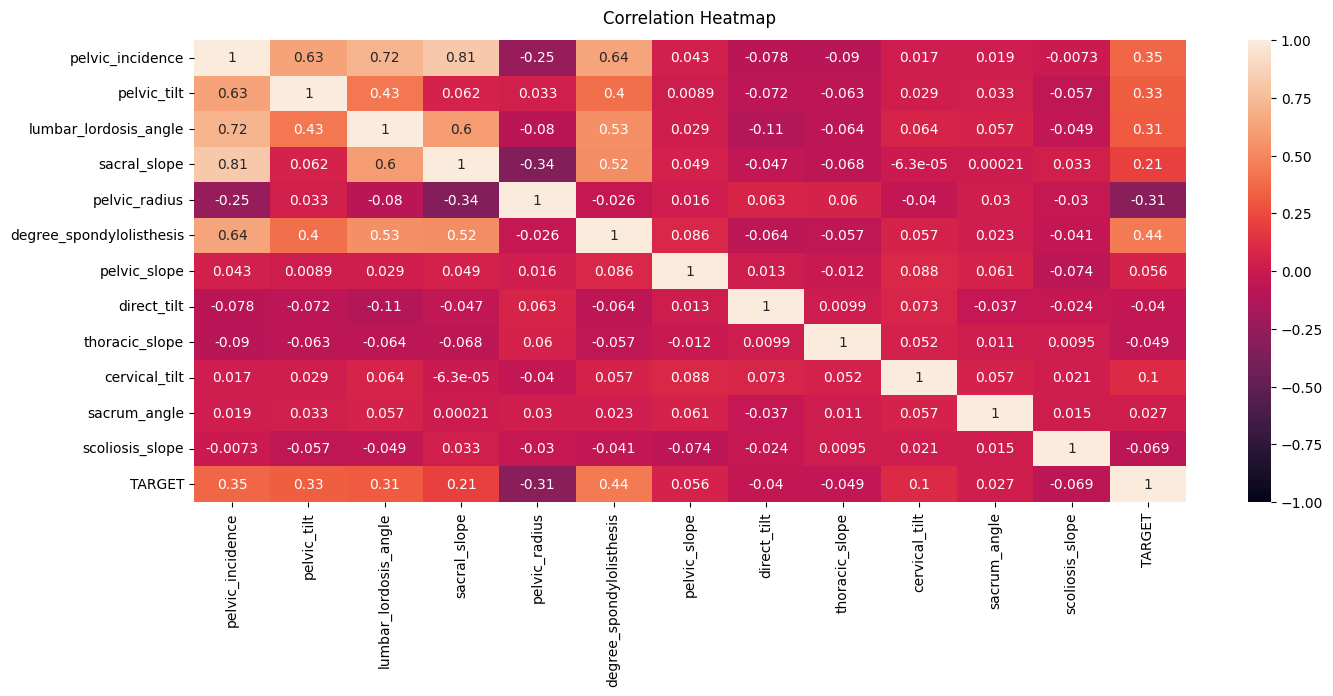

In [14]:
plt.figure(figsize=(16, 6))
hm = sns.heatmap(base.corr(numeric_only=True), annot=True, vmin=-1, vmax=1);
hm.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [15]:
# features whose correlation coefficient are close to 0 and statistically significant
irrel_columns = []
for col in base.columns:
    res = pearsonr(base[col], base.TARGET)
    if res.pvalue > 0.05:
        irrel_columns.append(col)
irrel_columns

['pelvic_slope',
 'direct_tilt',
 'thoracic_slope',
 'cervical_tilt',
 'sacrum_angle',
 'scoliosis_slope']

#### Separando em treino e teste.

In [16]:
X_ = base.loc[:, base.columns != 'TARGET']
y_ = base.TARGET

X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

In [17]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [18]:
#X_train.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'cervical_tilt']
#X_test.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'cervical_tilt']

In [19]:
X_train.shape

(232, 12)

In [20]:
X_test.shape

(78, 12)

#### Treinando modelos diferentes
Precisamos definir qual será a métrica de avaliação do modelo, meu palpite é ROC AUC pq tem mais informação. Optar sempre pela menor rede que nos dá bons resultados!

In [21]:
model   = MLPClassifier(hidden_layer_sizes=(64,32,16,8), activation="tanh", random_state=42, max_iter=450).fit(X_train, y_train) #melhores modelos
#model_2 = MLPClassifier(hidden_layer_sizes=(16,8,4), activation="tanh", random_state=42, max_iter=550).fit(X_train, y_train)
#model_2 = MLPClassifier(hidden_layer_sizes=(64,32), activation="tanh", random_state=42, max_iter=550).fit(X_train, y_train)
model_2 = MLPClassifier(hidden_layer_sizes=(32,16), activation="tanh", random_state=42, max_iter=550).fit(X_train, y_train)
model_3 = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=900).fit(X_train, y_train)
#model_4 = MLPClassifier(hidden_layer_sizes=(8,4), activation="tanh", random_state=42, max_iter=1450).fit(X_train, y_train)
model_4 = MLPClassifier(hidden_layer_sizes=(32), activation="tanh", random_state=42, max_iter=1600).fit(X_train, y_train)

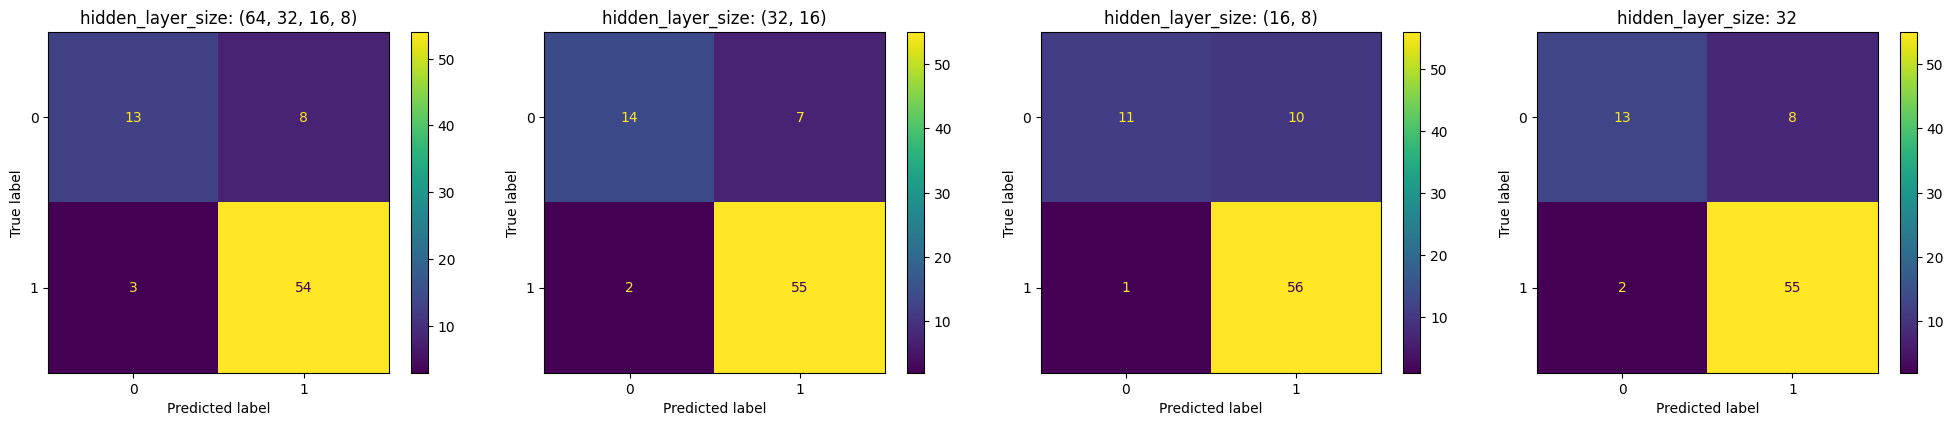

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,4))
fig.tight_layout()

models = [model, model_2, model_3, model_4]
results = []

for i in range(4):
    results += [plot_confusion_matrix(models[i], X_test, y_test, ax[i])]
    ax[i].set_title('hidden_layer_size: ' + str(models[i].hidden_layer_sizes))

plt.show()

In [23]:
all_feat = pd.DataFrame(results).sort_values(by='roc', ascending=False)
all_feat

model_shape  precision    recall        f1  accuracy       roc
0  (64, 32, 16, 8)   0.870968  0.947368  0.907563  0.858974  0.947368
2          (16, 8)   0.848485  0.982456  0.910569  0.858974  0.939850
1         (32, 16)   0.887097  0.964912  0.924370  0.884615  0.937343
3               32   0.873016  0.964912  0.916667  0.871795  0.935673

In [24]:
corr_base = base.loc[:, [col for col in base.columns if col not in irrel_columns]]

In [25]:
X_corr_ = corr_base.loc[:, corr_base.columns != 'TARGET']
y_corr_ = corr_base.TARGET

X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(
X_corr_, y_corr_, test_size=0.25, random_state=42)

In [26]:
X_train_corr.shape

(232, 6)

In [27]:
X_test_corr.shape

(78, 6)

In [28]:
X_train_corr = pd.DataFrame(scaler.fit_transform(X_train_corr))
X_test_corr = pd.DataFrame(scaler.fit_transform(X_test_corr))

In [29]:
corr_model   = MLPClassifier(hidden_layer_sizes=(64,32,16,8), activation="tanh", random_state=42, max_iter=450).fit(X_train_corr, y_train_corr)
corr_model_2 = MLPClassifier(hidden_layer_sizes=(32,16), activation="tanh", random_state=42, max_iter=550).fit(X_train_corr, y_train_corr)
corr_model_3 = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=900).fit(X_train_corr, y_train_corr)
#corr_model_4 = MLPClassifier(hidden_layer_sizes=(10,4), activation="tanh", random_state=42, max_iter=1450).fit(X_train_corr, y_train_corr) # MELHORes MODELO
corr_model_4 = MLPClassifier(hidden_layer_sizes=(16,), activation="tanh", random_state=42, max_iter=1450).fit(X_train_corr, y_train_corr) # MELHORes MODELO

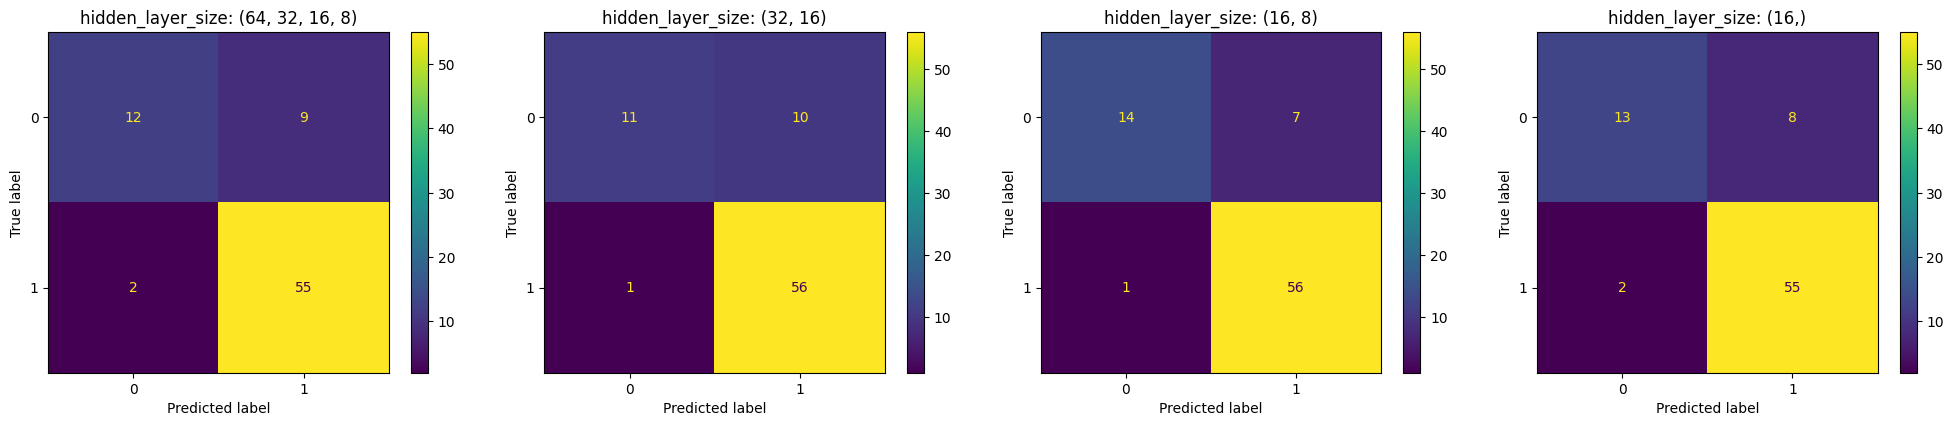

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,4))
fig.tight_layout()

corr_models = [corr_model, corr_model_2, corr_model_3, corr_model_4]
results = []

for i in range(4):
    results += [plot_confusion_matrix(corr_models[i], X_test_corr, y_test_corr, ax[i])]
    ax[i].set_title('hidden_layer_size: ' + str(corr_models[i].hidden_layer_sizes))

plt.show()

In [31]:
corr_feat = pd.DataFrame(results).sort_values(by=['accuracy','roc'], ascending=False)
corr_feat

model_shape  precision    recall        f1  accuracy       roc
2          (16, 8)   0.888889  0.982456  0.933333  0.897436  0.942356
3            (16,)   0.873016  0.964912  0.916667  0.871795  0.942356
1         (32, 16)   0.848485  0.982456  0.910569  0.858974  0.942356
0  (64, 32, 16, 8)   0.859375  0.964912  0.909091  0.858974  0.942356

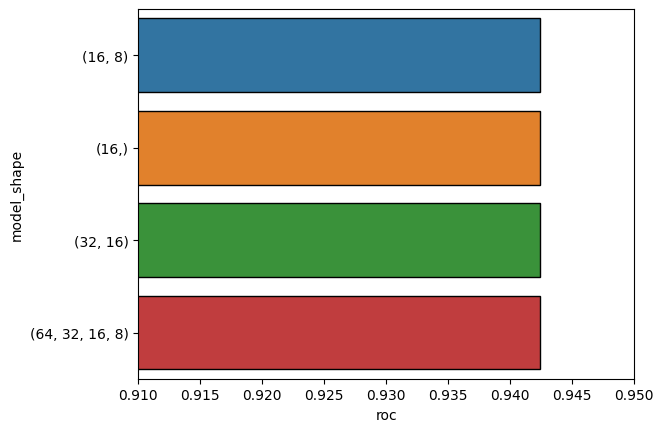

In [32]:
sns.barplot(data=corr_feat, y='model_shape', x='roc', edgecolor='black')
plt.xlim((0.91,0.95))
plt.show()

In [33]:
losses_4 = corr_model_4.loss_curve_
losses_3 = corr_model_3.loss_curve_
losses_2 = corr_model_2.loss_curve_
losses = corr_model.loss_curve_

<Axes: >

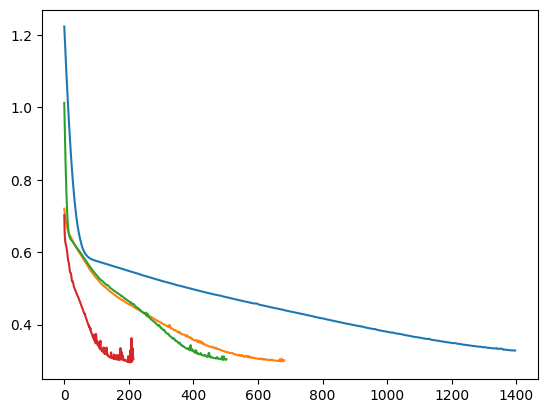

In [34]:
sns.lineplot(losses_4)
sns.lineplot(losses_3)
sns.lineplot(losses_2)
sns.lineplot(losses)

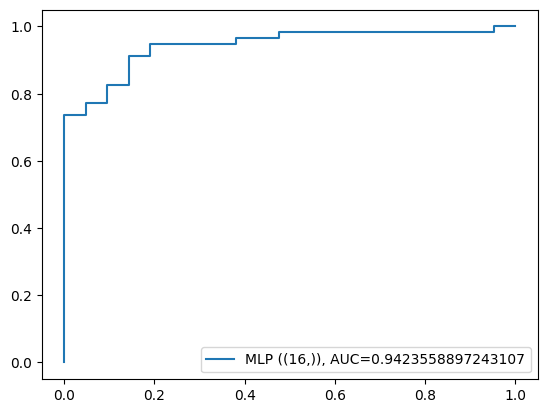

In [36]:
y_pred_prob = corr_model_4.predict_proba(X_test_corr)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_corr, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="MLP (" + str(corr_model_4.hidden_layer_sizes) + "), AUC="+str(roc_auc))


plt.legend()
plt.show()